# Image Augmentation

This notebook performs data augmentation of the original dataset. The following operations are applied to the images at random to generate a new sample:

* Vertical flip
* Horizontal flip
* Rotation

We may also try:

* Scale and crop
* Random noise
* Change contrast
* Logarithmic and sigmoid correction

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import skimage

from matplotlib.pyplot import imshow

%matplotlib inline

## Load images

In [2]:
data_path = os.path.join(os.getcwd(), '..', 'input')

In [3]:
with open(os.path.join(data_path, 'train_images_256x256.pkl'), 'rb') as fin:
    images = pickle.load(fin)
with open(os.path.join(data_path, 'train_responses.pkl'), 'rb') as fin:
    responses = pickle.load(fin)
with open(os.path.join(data_path, 'train_scores.pkl'), 'rb') as fin:
    scores = pickle.load(fin)

In [4]:
positive_images = images[responses.squeeze() == 1., :, :, :]
positive_scores = scores[responses.squeeze() == 1., :]
positive_responses = responses[responses.squeeze() == 1., :]
negative_images = images[responses.squeeze() == 0., :, :, :]
negative_scores = scores[responses.squeeze() == 0., :]
negative_responses = responses[responses.squeeze() == 0., :]

## Augment a single image

Let's create a function that given an image, it'll create a new one derived from it.

In [5]:
def augment(image, threshold=.5, height=256, width=256, randoms=None):
    if randoms is None:
        randoms = np.random.random(5)
        while sum(randoms < threshold) < 3:
            # Perform at least 3 operations
            randoms = np.random.random(5)
        randoms = randoms.tolist()
    if randoms[0] < threshold:
        # Flip horizontally
        image = image[:, ::-1, :]
    if randoms[1] < threshold:
        # Flip vertically
        image = image[::-1, :, :]
    # if randoms[2] < 0.:
    #     # Change contrast
    #     v_min, v_max = np.percentile(image, (.02 * random.random(), 100. - .02 * random.random()))
    #     image = skimage.exposure.rescale_intensity(image, in_range=(v_min, v_max))
    if randoms[2] < threshold:
        # Rotate (reflect mode)
        image = skimage.transform.rotate(image, angle=random.random() * 360., mode='reflect', preserve_range=True)
    if randoms[3] < threshold:
        # Random noise (custom and subtle)
        image = (image + (np.random.randn(256, 256, 3) * 2.)).clip(min=0., max=255.)
    if randoms[4] < threshold:
        # Scale outwards and crop
        image = skimage.transform.rescale(
            image, scale=(random.random() * .3 + 1., random.random() * .3 + 1.),
            multichannel=True, mode='reflect', anti_aliasing=True, preserve_range=True
        )
        new_height, new_width, _ = image.shape
        start_height = random.choice(range(0, new_height - height + 1))
        start_width = random.choice(range(0, new_width - width + 1))
        image = image[start_height:start_height + height, start_width: start_width + width, :]
    return image.astype(np.uint8)

Now let's test this function with a sample image:

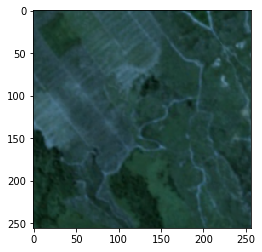

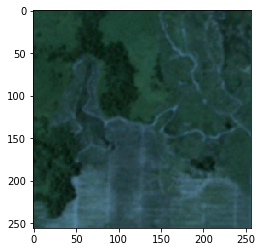

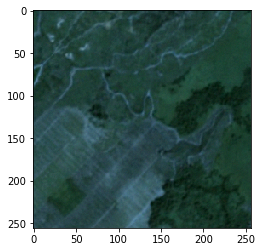

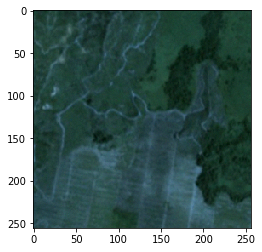

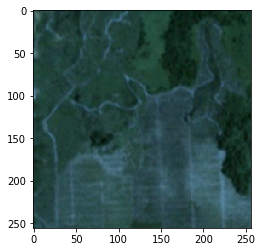

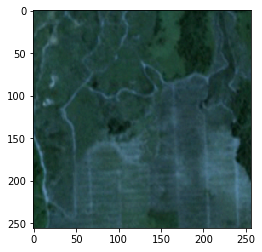

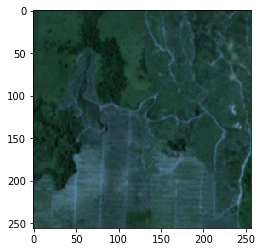

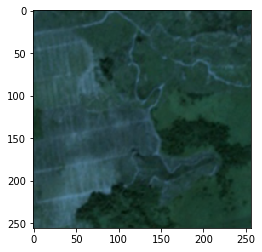

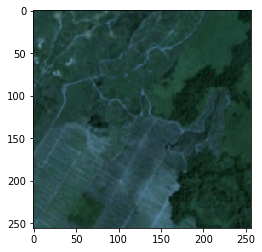

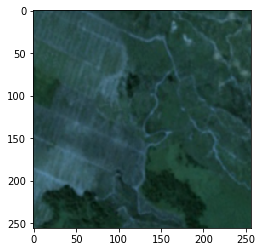

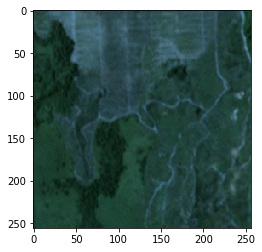

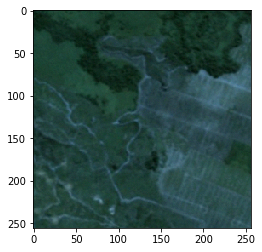

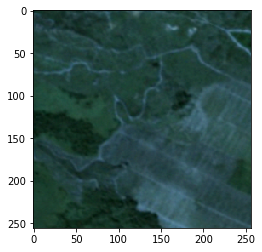

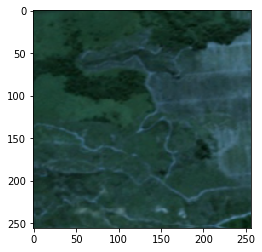

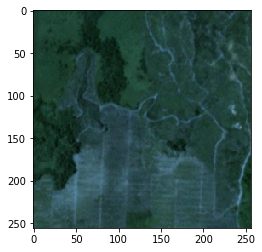

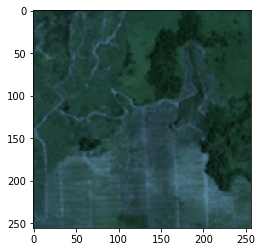

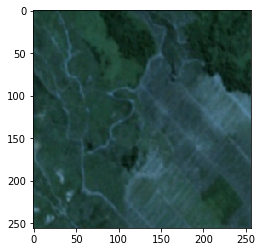

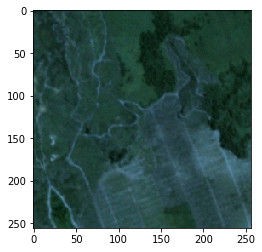

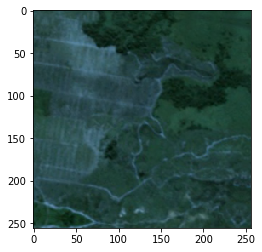

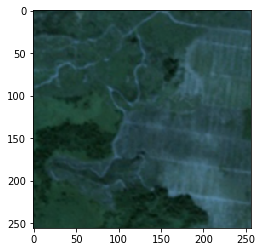

In [6]:
image = positive_images[0, :, :, :]
for _ in range(20):
    plt.figure()
    imshow(augment(image))

## Generate augmented data

In [7]:
augmented_images = []
augmented_scores = []
augmented_responses = []

First, we do it for positive cases, we generate **10x** the amount of current positive images:

In [8]:
for i in range(positive_images.shape[0]):
    score = positive_scores[i, :]
    response = positive_responses[i, :]
    # Vertical flip + noise
    image = augment(positive_images[i, :, :, :], randoms=[1., 0., 1., 0., 1.]).reshape(1, 256, 256, 3)
    augmented_images.append(image)
    augmented_scores.append(score)
    augmented_responses.append(response)
    # Horizontal flip + noise
    image = augment(positive_images[i, :, :, :], randoms=[0., 1., 1., 0., 1.]).reshape(1, 256, 256, 3)
    augmented_images.append(image)
    augmented_scores.append(score)
    augmented_responses.append(response)
    # Random rotation + noise
    image = augment(positive_images[i, :, :, :], randoms=[1., 1., 0., 0., 1.]).reshape(1, 256, 256, 3)
    augmented_images.append(image)
    augmented_scores.append(score)
    augmented_responses.append(response)

Due to class imbalance, we don't need that many negative images. Let's generate **1/3** of the images generated in the positive dataset by augmenting a subset of the negative set. We generate a single augmented image for each image we sample:

In [9]:
# for i in random.sample(range(negative_images.shape[0]), int(len(augmented_images) / 3)):
#     score = negative_scores[i, :]
#     response = negative_responses[i, :]
#     image = augment(negative_images[i, :, :, :]).reshape(1, 256, 256, 3)
#     augmented_images.append(image)
#     augmented_scores.append(score)
#     augmented_responses.append(response)

Finally, we combine these images into a single *ndarray* and shuffle it.

In [10]:
augmented_images = np.concatenate(augmented_images, axis=0)
augmented_scores = np.concatenate(augmented_scores, axis=0).reshape(augmented_images.shape[0], 1)
augmented_responses = np.concatenate(augmented_responses, axis=0).reshape(augmented_images.shape[0], 1)

In [11]:
permutation = np.random.permutation(augmented_images.shape[0])
augmented_images = augmented_images[permutation, :, :, :]
augmented_scores = augmented_scores[permutation, :]
augmented_responses = augmented_responses[permutation, :]

## Pickle augmented images for future usage

In [12]:
with open(os.path.join(data_path, 'augmented_images_256x256.pkl'), 'wb') as fout:
    pickle.dump(augmented_images, fout, protocol=4)
with open(os.path.join(data_path, 'augmented_responses.pkl'), 'wb') as fout:
    pickle.dump(augmented_responses, fout, protocol=4)
with open(os.path.join(data_path, 'augmented_scores.pkl'), 'wb') as fout:
    pickle.dump(augmented_scores, fout, protocol=4)